The goal of this notebook is to replicate the work of DBauer1999 (Bauer, D., & Mulser, P. (1999). Exact field ionization rates in the barrier-suppression regime from numerical time-dependent Schrödinger-equation calculations. Physical Review A, 59(1), 569–577. https://doi.org/10.1103/PhysRevA.59.569) and investigate correspondence between their results and our IDE model.

In [1]:
import logging
import os
import functools
import datetime

import numpy as np
import scipy.optimize as optim

import simulacra as si
import simulacra.units as u

import ionization as ion

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

LOGMAN = si.utils.LogManager('simulacra', 'ionization', stdout_level = logging.INFO)
THIS_DIR = os.getcwd()
OUT_DIR = os.path.join(THIS_DIR, 'out', 'Bauer1999')
SIM_LIB = os.path.join(OUT_DIR, 'SIMLIB')

PLOT_KWARGS = dict(
    show = True,
    save = True,
    target_dir = OUT_DIR,
    img_format = 'png',
    fig_dpi_scale = 1.5,
)

CHECKPOINT_KWARGS = dict(
    checkpoints = True,
    checkpoint_dir = SIM_LIB,
    checkpoint_every = datetime.timedelta(minutes = 1),
)

%matplotlib inline

One of the key figures in the paper is the fifth, which shows a comparison of different tunneling rates. I reproduce that figure here.

Note that we need to double the "tunneling rates" as calculated by my rate models to get the same plot as Bauer. This is because Bauer gives the tunneling rates in terms of the probability to remain bound, while mine effect the wavefunction directly (they're implemented this way so that they can be shared with the IDE model simulations, which need to act on the wavefunction itself, not it's square).

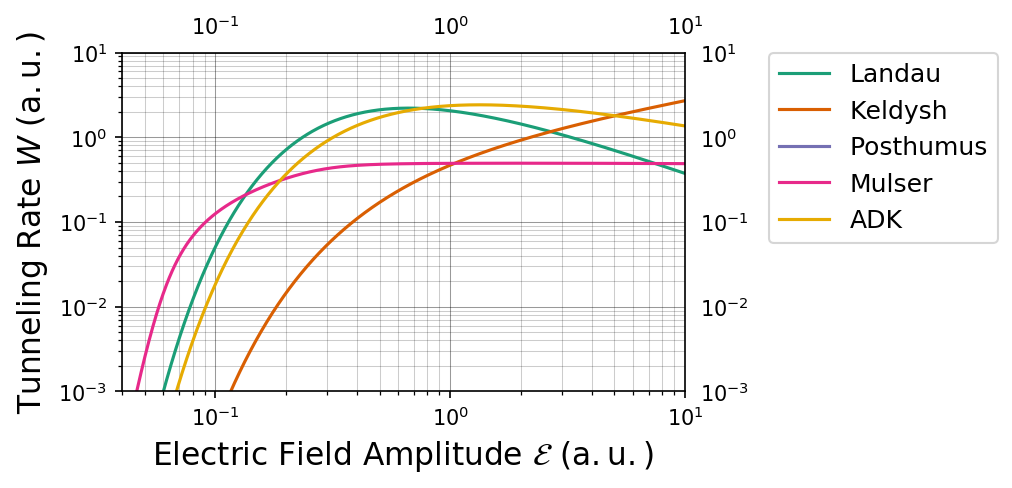

In [2]:
def make_dbauer1999_fig_5():
    tunneling_models = [
        ion.tunneling.LandauRate(),
        ion.tunneling.KeldyshRate(),
        ion.tunneling.PosthumusRate(),
        ion.tunneling.MulserRate(),
        ion.tunneling.ADKRate(),
        # ion.tunneling.ADKExtendedToBSIRate(),  # this one isn't working yet
    ]

    amplitudes = np.geomspace(.04, 10, 1000) * u.atomic_electric_field

    tunneling_rates = [
        np.abs(model.tunneling_rate(amplitudes, -u.rydberg).squeeze())
        for model in tunneling_models
    ]
    labels = [model.__class__.__name__.rstrip('Rate') for model in tunneling_models]
    
    colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#e6ab02','#66a61e']

    si.vis.xy_plot(
        'tunneling_rates',
        amplitudes,
        *[2 * tr for tr in tunneling_rates],
        line_labels = labels,
        line_kwargs = [{'color': c} for c in colors[:len(tunneling_models)]],
        x_label = r'Electric Field Amplitude $ \mathcal{E} $',
        y_label = r'Tunneling Rate $ W $',
        x_unit = 'atomic_electric_field',
        y_unit = 'per_atomic_time',
        x_log_axis = True,
        y_log_axis = True,
        y_lower_limit = .001 / u.atomic_time,
        y_upper_limit = 10 / u.atomic_time,
        y_log_pad = 1,
        legend_on_right = True,
        **PLOT_KWARGS
    )
    
make_dbauer1999_fig_5()

This is the laser pulse used by Bauer1999. It is not centered at $t=0$, but instead at half the number of cycles times the cycle time (i.e., the number of periods and the period). Note that $\varphi = 0$ is a sine-like pulse because of this time shift. 

In [3]:
class BauerGaussianPulse(ion.potentials.UniformLinearlyPolarizedElectricPotential):
    """Gaussian pulse as defined in DBauer1999. Phase = 0 is a sine-like pulse."""

    def __init__(
            self,
            amplitude = 0.3 * u.atomic_electric_field,
            omega = .2 * u.atomic_angular_frequency,
            number_of_cycles = 6,
            phase = 0,
            **kwargs):
        super().__init__(**kwargs)

        self.amplitude = amplitude
        self.omega = omega
        self.number_of_cycles = number_of_cycles
        self.phase = phase

        self.pulse_center = number_of_cycles * u.pi / self.omega
        self.sigma2 = (self.pulse_center ** 2 / (4 * np.log(20)))

    @property
    def cycle_time(self):
        return 2 * self.pulse_center / self.number_of_cycles

    def get_electric_field_envelope(self, t):
        return np.exp(-((t - self.pulse_center) ** 2) / (4 * self.sigma2))

    def get_electric_field_amplitude(self, t):
        amp = self.get_electric_field_envelope(t) * np.sin((self.omega * t) + self.phase)

        return amp * self.amplitude * super().get_electric_field_amplitude(t)
    
    @property
    def identifier(self):
        return f'E={u.uround(self.amplitude, u.atomic_electric_field, 2)}_Nc={self.number_of_cycles}_omega={u.uround(self.omega, u.atomic_angular_frequency, 2)}'

Bauer1999 recommends a tunneling model given by $W = -2.4 \, \mathcal{E}^2$ when the electric field is larger than the critical field, and by the Landau tunneling rate below that. Here's that as a `TunnelingModel`. Remember that that prefactor, $-2.4$, corresponds to $-1.2$ the way I do things.

In [4]:
class BauerLandauRate(ion.tunneling.LandauRate):
    def __init__(self, prefactor = -1.2):
        super().__init__()
        
        self.prefactor = prefactor
        
    def _tunneling_rate(self, electric_field_amplitude, ionization_potential):
        landau_rate = super()._tunneling_rate(electric_field_amplitude, ionization_potential)
        bauer_rate = self.empirical_rate(electric_field_amplitude)
        
        critical_field = self.critical_electric_field_amplitude(ionization_potential)
        
        rate = np.where(
            np.abs(electric_field_amplitude) <= critical_field,
            landau_rate,
            bauer_rate,
        ).squeeze()

        return rate
    
    def empirical_rate(self, electric_field_amplitude):
        scaled_amplitude = np.abs(electric_field_amplitude) / u.atomic_electric_field
        empirical_rate = self.prefactor * (scaled_amplitude ** 2) / u.atomic_time
        
        return empirical_rate
    
    def critical_electric_field_amplitude(self, ionization_potential):
        """Determine the electric field amplitude where the empirical and tunneling rates are equal, which is where we should switch over."""
        sup = super()
        critical_field = optim.brentq(
            lambda amp: sup._tunneling_rate(amp, ionization_potential) - self.empirical_rate(amp),
            .01 * u.atomic_electric_field,
            .5 * u.atomic_electric_field,
        )

        return critical_field

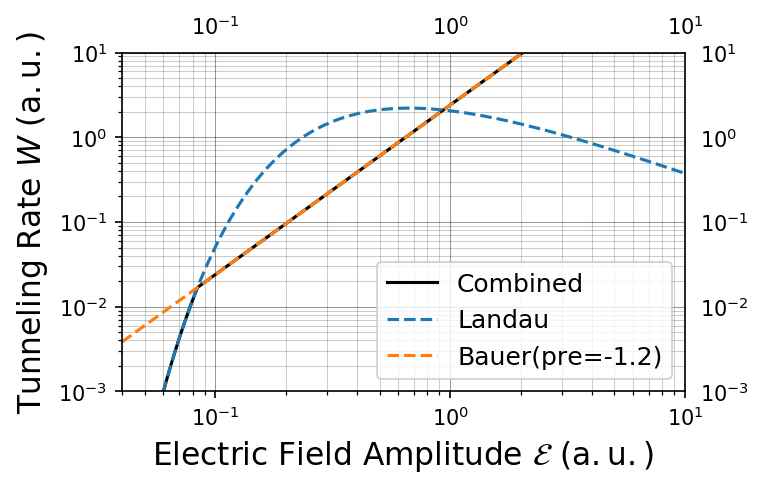

In [5]:
def plot_combined_bauer_landau_tunneling_rate():
    amplitudes = np.geomspace(.04, 10, 1000) * u.atomic_electric_field
    landau_model = ion.tunneling.LandauRate()
    bauer_model = BauerLandauRate()
    si.vis.xy_plot(
        'bauer_landau_tunneling_rate',
        amplitudes,
        2 * np.abs(bauer_model.tunneling_rate(amplitudes, -u.rydberg)),
        2 * np.abs(landau_model.tunneling_rate(amplitudes, -u.rydberg)),
        2 * np.abs(bauer_model.empirical_rate(amplitudes)),
        line_labels = [
            r'Combined',
            r'Landau',
            rf'Bauer(pre={bauer_model.prefactor})',
        ],
        line_kwargs = [
            {'color': 'black'},
            {'linestyle': '--'},
            {'linestyle': '--'},
        ],
        x_label = r'Electric Field Amplitude $ \mathcal{E} $',
        y_label = r'Tunneling Rate $ W $',
        x_unit = 'atomic_electric_field',
        y_unit = 'per_atomic_time',
        x_log_axis = True,
        y_log_axis = True,
        y_lower_limit = .001 * u.per_atomic_time,
        y_upper_limit = 10 * u.per_atomic_time,
        y_log_pad = 1,
        **PLOT_KWARGS
    )
    
plot_combined_bauer_landau_tunneling_rate()

Let's run simulations for the TDSE (radial/spherical-harmonic mesh), and Bauer's tunneling model.

In [ ]:
amplitudes = np.array([.3, .5]) * u.atomic_electric_field
number_of_cycles = [6, 12]
pulses = [
    BauerGaussianPulse(
        amplitude = amp,
        number_of_cycles = nc,
        omega = .2 * u.atomic_angular_frequency,
        phase = 0,
    )
    for amp in amplitudes
    for nc in number_of_cycles
]

def time_and_field(pulse):
    return dict(
        time_initial = -pulse.pulse_center,
        time_final = 3 * pulse.pulse_center,
        time_step = 1 * u.asec,
        electric_potential = pulse,
    )

R = 100 * u.bohr_radius
N = 100 * 10
L = 300
mesh_identifier = f'R={u.uround(R, u.bohr_radius, 0)}_N={N}_L={L}'
tdse_specs = [
    ion.mesh.SphericalHarmonicSpecification(
        '_'.join(('TDSE', pulse.identifier, mesh_identifier)),
        r_bound = R,
        r_points = N,
        l_bound = L,
        **time_and_field(pulse),
        mask = ion.potentials.RadialCosineMask(inner_radius = .8 * R, outer_radius = R),
        use_numeric_eigenstates = True,
        numeric_eigenstate_max_energy = 20 * u.eV,
        numeric_eigenstate_max_angular_momentum = 10,
        datastores = [
            ion.mesh.Fields(),
            ion.mesh.Norm(),
            ion.mesh.InnerProducts(),
            ion.mesh.RExpectationValue(),
            ion.mesh.ZExpectationValue(),
            ion.mesh.InternalEnergyExpectationValue(),
            ion.mesh.TotalEnergyExpectationValue(),
            ion.mesh.NormWithinRadius(radii = np.array([5, 10, 20]) * u.bohr_radius),
        ],
        **CHECKPOINT_KWARGS,
    )
    for pulse in pulses
]

prefactor = -1.2  # aka the default; the value found by Bauer1999

tunneling_specs = [
    ion.tunneling.TunnelingSpecification(
        'TUNN_' + pulse.identifier + f'_prefactor={prefactor}',
        **time_and_field(pulse),
        tunneling_model = BauerLandauRate(prefactor = prefactor),
        ionization_potential = -u.rydberg,
    )
    for pulse in pulses
]

tdse_results = [si.utils.run_from_simlib(spec, simlib = SIM_LIB, progress_bar = True) for spec in tdse_specs]
tunneling_results = [si.utils.run_from_simlib(spec, simlib = SIM_LIB, progress_bar = True) for spec in tunneling_specs]

TDSE_E=0.3_Nc=6_omega=0.2_R=100.0_N=1000_L=300
C:\Users\joshk\GitHubProjects\ionization\science\bauer\out\Bauer1999\SIMLIB
C:\Users\joshk\GitHubProjects\ionization\science\bauer\out\Bauer1999\SIMLIB\TDSE_E=0.3_Nc=6_omega=0.2_R=100.0_N=1000_L=300.sim
nope


c:\users\joshk\githubprojects\ionization\src\ionization\mesh\sims.py:64: RuntimeWarning: overflow encountered in long_scalars
  self.spacetime_points = np.prod(self.mesh.g.shape) * self.time_steps
 46%|#################9                     | 4200/9118 [28:41<34:37,  2.37it/s]

Using these simulations we can reproduce figure 7. Note that Bauer uses the norm within $5 a_0$ as the ionization metric, as opposed to the initial state overlap, which is what I like to use, so this isn't an exact reproduction.

In [ ]:
def make_dbauer1999_fig_7(pulses, tdse_sims, tunneling_sims):
    longest_pulse = max(pulses, key = lambda p: p.pulse_center)

    x_data = []
    y_data = []
    line_labels = []
    line_kwargs = []
    
    colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a',]
    styles = ['-', '--',]
    
    color_labels = [sim.spec.electric_potential.identifier.replace('_', ',').replace('E', '\mathcal{E}_0').replace('Nc', 'N').replace('omega', '\omega')
                    for sim in tdse_sims]
    color_patches = [
        mpatches.Patch(
            color = color,
            label = f"$ {label} $",
        )
        for color, label in zip(colors, color_labels)
    ]

    style_labels = ['TDSE', 'TUNN']
    style_patches = [
        mlines.Line2D(
            [], [],
            color = 'black',
            linestyle = style, 
            linewidth = 1,
            label = sim_type,
        )
        for style, sim_type in zip(styles, style_labels)
    ]
    
    for tdse_sim, tunneling_sim, color in zip(tdse_sims, tunneling_sims, colors):
        x_data.append(tdse_sim.data.times)
        y_data.append(tdse_sim.data.initial_state_overlap)
        
        x_data.append(tunneling_sim.times)
        y_data.append(tunneling_sim.b2)

        for style in styles:
            line_kwargs.append({'linestyle': style, 'color': color})

    legend_handles = color_patches + style_patches

    si.vis.xxyy_plot(
        f'Bauer1999_fig7',
        x_data,
        y_data,
        line_labels = line_labels,
        line_kwargs = line_kwargs,
        x_label = r'$t$ (cycles of longest pulse)',
        x_unit = 2 * longest_pulse.pulse_center / longest_pulse.number_of_cycles,
        x_lower_limit = 0,
        x_upper_limit = longest_pulse.pulse_center,
        y_label = r'Initial State Overlap',
        y_lower_limit = 0,
        y_upper_limit = 1,
        y_pad = 0,
        font_size_legend = 9,
        legend_kwargs = dict(
            handles = legend_handles,
        ),
        legend_on_right = True,
        **PLOT_KWARGS
    )

make_dbauer1999_fig_7(pulses, tdse_results, tunneling_results)

Let's see if we can reproduce any of these features using the IDE model:

In [ ]:
class LandauBelowCriticalField(BauerLandauRate):
    """A trick tunneling model for comparisons with the IDE model: the Landau model, but it cuts off at the critical field."""
    def _tunneling_rate(self, electric_field_amplitude, ionization_potential):
        landau_rate = super()._tunneling_rate(electric_field_amplitude, ionization_potential)
        
        critical_field = self.critical_electric_field_amplitude(ionization_potential)
        
        rate = np.where(
            np.abs(electric_field_amplitude) <= critical_field,
            landau_rate,
            0,
        ).squeeze()

        return rate

def plot_landau_below_critical_field_rate():
    amplitudes = np.geomspace(.04, 10, 1000) * u.atomic_electric_field
    landau_model = LandauBelowCriticalField()
    si.vis.xy_plot(
        'landau_below_critical_field_rate',
        amplitudes,
        2 * np.abs(landau_model.tunneling_rate(amplitudes, -u.rydberg)),
        line_labels = [
            r'Landau Below Critical Field',
        ],
        x_label = r'Electric Field Amplitude $ \mathcal{E} $',
        y_label = r'Tunneling Rate $ W $',
        x_unit = 'atomic_electric_field',
        y_unit = 'per_atomic_time',
        x_log_axis = True,
        y_log_axis = True,
        y_lower_limit = .001 * u.per_atomic_time,
        y_upper_limit = 10 * u.per_atomic_time,
        y_log_pad = 1,
        **PLOT_KWARGS
    )
    
plot_landau_below_critical_field_rate()

In [ ]:
ide_specs = [
    ion.ide.IntegroDifferentialEquationSpecification(
        'IDE_' + pulse.identifier,
        **time_and_field(pulse),
        ionization_potential = -u.rydberg,
        tunneling_model = ion.tunneling.NoTunneling(),
        **CHECKPOINT_KWARGS,
    )
    for pulse in pulses
]

prefactor = -1.2
ide_with_tunneling_specs = [
    ion.ide.IntegroDifferentialEquationSpecification(
        'IDE_' + pulse.identifier + f'_prefactor={prefactor}',
        **time_and_field(pulse),
        tunneling_model = LandauBelowCriticalField(prefactor = prefactor),
        ionization_potential = -u.rydberg,
        **CHECKPOINT_KWARGS,
    )
    for pulse in pulses
]

ide_results = [si.utils.run_from_simlib(spec, simlib = SIM_LIB, progress_bar = True) for spec in ide_specs]
ide_with_tunneling_results = [si.utils.run_from_simlib(spec, simlib = SIM_LIB, progress_bar = True) for spec in ide_with_tunneling_specs]

In [ ]:
def compare_ide_to_bauer(pulses, tdse_sims, tunneling_sims, ide_sims, postfix = '', title = ''):
    longest_pulse = max(pulses, key = lambda p: p.pulse_center)

    x_data = []
    y_data = []
    line_labels = []
    line_kwargs = []
    
    colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a',]
    styles = ['-', '--', ':',]
    
    color_labels = [sim.spec.electric_potential.identifier.replace('_', ',').replace('E', '\mathcal{E}_0').replace('Nc', 'N').replace('omega', '\omega')
                    for sim in tdse_sims]
    color_patches = [
        mpatches.Patch(
            color = color,
            label = f"$ {label} $",
        )
        for color, label in zip(colors, color_labels)
    ]

    style_labels = ['TDSE', 'TUNN', 'IDE']
    style_patches = [
        mlines.Line2D(
            [], [],
            color = 'black',
            linestyle = style, 
            linewidth = 1,
            label = sim_type,
        )
        for style, sim_type in zip(styles, style_labels)
    ]
    
    for tdse_sim, tunneling_sim, ide_sim, color in zip(tdse_sims, tunneling_sims, ide_sims, colors):
        x_data.append(tdse_sim.data.times)
        y_data.append(tdse_sim.data.initial_state_overlap)
        
        x_data.append(tunneling_sim.times)
        y_data.append(tunneling_sim.b2)
        
        x_data.append(ide_sim.times)
        y_data.append(ide_sim.b2)

        for style in styles:
            line_kwargs.append({'linestyle': style, 'color': color})

    legend_handles = color_patches + style_patches

    si.vis.xxyy_plot(
        f'compare_ide_to_bauer' + postfix,
        x_data,
        y_data,
        line_labels = line_labels,
        line_kwargs = line_kwargs,
        x_label = r'$t$ (cycles of longest pulse)',
        x_unit = 2 * longest_pulse.pulse_center / longest_pulse.number_of_cycles,
        x_lower_limit = 0,
        x_upper_limit = longest_pulse.pulse_center,
        y_label = r'Initial State Overlap',
        y_lower_limit = 0,
        y_upper_limit = 1,
        y_pad = 0,
        font_size_legend = 9,
        title = title,
        legend_kwargs = dict(
            handles = legend_handles,
        ),
        fontsize_legend = 5,
        legend_on_right = True,
        **PLOT_KWARGS
    )

compare_ide_to_bauer(pulses, tdse_results, tunneling_results, ide_results, title = 'Plain IDE')
compare_ide_to_bauer(pulses, tdse_results, tunneling_results, ide_with_tunneling_results, postfix = '_with_tunneling', title = 'IDE w/ Tunneling')

Well, that's not very inspiring. However, there is a ray of hope: there's certainly lots of action in the IDE model, it's just not causing ionization. When I ran through the calculation that would yield the instantaneous ionization rate, you get the right order of magnitude, but it's imaginary instead of real! That would, of course, cause oscillations instead of decay. What if we try...

In [ ]:
class NotTheHydrogenKernel(ion.ide.LengthGaugeHydrogenKernel):
    def _evaluate_kernel_function(self, time_difference):
        return 1j * super()._evaluate_kernel_function(time_difference)
    
prefactor = -1.2
ide_with_mod_kernel_specs = [
    ion.ide.IntegroDifferentialEquationSpecification(
        'IDE_' + pulse.identifier + f'_prefactor={prefactor}' + '_mod_kernel',
        **time_and_field(pulse),
        kernel = NotTheHydrogenKernel(),
        tunneling_model = LandauBelowCriticalField(prefactor = prefactor),
        ionization_potential = -u.rydberg,
        **CHECKPOINT_KWARGS,
    )
    for pulse in pulses
]

ide_with_mod_kernel_results = [si.utils.run_from_simlib(spec, simlib = SIM_LIB, progress_bar = True) for spec in ide_with_mod_kernel_specs]

compare_ide_to_bauer(pulses, tdse_results, tunneling_results, ide_with_mod_kernel_results, postfix = '_with_mod_kernel', title = 'IDE w/ Tunneling + Modified Kernel')

Hey, that's not half-bad! Especially for the six-cycle pulses, which are shorter than the twelve-cycle pulses. It's worst for the longest, weakest pulse, which makes sense based on where we've found the best agreement for the IDE model with sinc pulses (short and strong).

Unfortunately, it's total nonsense: all we did is change the overall phase of the kernel, which we know isn't the right thing to do. But it does indicate that there's some kind of phase change in the kernel (i.e., in our approximate kernel compared to the "real" kernel) that we only see as the pulse gets longer. So our next step is to try to get better kernels which reproduce the ionization rate for these long pulses. All indications so far point to these extra phase and amplitude factors hiding in the continuum-continuum interaction, which the simplest kernel ignores entirely.

Let's go back to real kernel functions. The next-easiest kernel to work with is one that include the "$\mathcal{A}^2$ phase term", which comes from the continuum-continuum interaction.

In [ ]:
prefactor = -1.2
ide_with_a2_phase_specs = [
    ion.ide.IntegroDifferentialEquationSpecification(
        'IDE_' + pulse.identifier + f'_prefactor={prefactor}' + '_a2_phase',
        **time_and_field(pulse),
        kernel = ion.ide.ApproximateLengthGaugeHydrogenKernelWithContinuumContinuumInteraction(),
        tunneling_model = LandauBelowCriticalField(prefactor = prefactor),
        ionization_potential = -u.rydberg,
        **CHECKPOINT_KWARGS,
    )
    for pulse in pulses
]

ide_with_a2_phase_results = [si.utils.run_from_simlib(spec, simlib = SIM_LIB, progress_bar = True) for spec in ide_with_a2_phase_specs]

compare_ide_to_bauer(pulses, tdse_results, tunneling_results, ide_with_a2_phase_results, postfix = '_with_a2_phase', title = r'IDE w/ Tunneling + $\mathcal{A}^2$ Phase')

Adding the more-correct phase factor seems to be having the desired effect: the kernel is becoming "net-real" for this longer pulse, thus causing ionization.